## Package preparation

In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.contrib import rnn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 12})
MARKER_SIZE = 2
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

In [3]:
TIME_STEPS = 168
OUTPUT_SIZE = 1 # next 6h
N_FOLD = 5
N_TASKS = 6

INTERVAL = "1h"

EX_PRED = 0
EXPLANATION_ = "Ion_closed_MT_LN" + "_I" + INTERVAL + "_T" + str(TIME_STEPS)
print(EXPLANATION_)

Ion_closed_MT_LN_I1h_T168


## Data preparation

In [4]:
ion_label = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")

In [5]:
ion_label = ion_label[~(ion_label.index < '2018-01-12')]
#ion_label.drop(["N"], axis=1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if "Unnamed:" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".1" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".2" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".3" in columns], axis= 1, inplace=True)
ion_label.dropna(inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-23"), pd.Timestamp("2018-04-12"), pd.Timestamp("2018-04-05")], axis=0, inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-05"), pd.Timestamp("2018-04-13")], axis=0, inplace=True)

In [6]:
ion_label.index += pd.Timedelta("16h")

In [7]:
ion_label = ion_label.sample(frac=1.0)

In [8]:
raw_closed = pd.read_csv("./results/closed_data.csv", index_col="TIMESTAMP")
raw_closed.index = pd.DatetimeIndex(raw_closed.index)
raw_closed = raw_closed[np.abs(raw_closed-raw_closed.mean())<=(3*raw_closed.std())]
raw_closed["RootTemp(1)"][0] = 20
raw_closed.drop(["ECS(3)", "InjDrgVR(3)", "DrgDaily(3)", "DrgV(3)"], axis=1, inplace=True)

In [9]:
raw_closed.interpolate("linear", inplace=True)

# raw_closed.index = (raw_closed.index).round(INTERVAL)
# raw_closed = raw_closed.groupby(raw_closed.index).mean()

In [10]:
MAXS = raw_closed.max()
MINS = raw_closed.min()
LABELMAXS = ion_label.max()
LABELMINS = ion_label.min()

In [11]:
raw_closed = (raw_closed - MINS) / (MAXS - MINS)
ion_label = (ion_label - LABELMINS) / (LABELMAXS - LABELMINS)

In [12]:
env_input = []
for index in ion_label.index:
    last_time = index
    first_time = last_time - pd.Timedelta(INTERVAL)*(TIME_STEPS-1)
    
    TRAIN_RANGE = pd.date_range(first_time, last_time, freq=INTERVAL)
    env_input.append(raw_closed.loc[TRAIN_RANGE])

In [13]:
for i in range(len(env_input)):
    env_input[i] = env_input[i].values
    
env_input = np.array(env_input)

In [14]:
env_input.shape

(52, 168, 23)

In [15]:
rnn_inputs = []
rnn_labels = []
pred_inputs = []
pred_labels = []

N_TEST = int(ion_label.shape[0]/N_FOLD)

for i in range(N_FOLD-1):
    pred_inputs.append(env_input[i*N_TEST:(i+1)*N_TEST, :, :])
    pred_labels.append(ion_label.iloc[i*N_TEST:(i+1)*N_TEST, :])
    
    rnn_inputs.append(np.delete(env_input, np.arange(i*N_TEST, (i+1)*N_TEST), 0))
    rnn_labels.append(ion_label.drop(ion_label.index[np.arange(i*N_TEST, (i+1)*N_TEST)], axis=0))



pred_inputs.append(env_input[(N_FOLD-1)*N_TEST:, :, :])
pred_labels.append(ion_label.iloc[(N_FOLD-1)*N_TEST:, :])

rnn_inputs.append(env_input[:(N_FOLD-1)*N_TEST:, :, :])
rnn_labels.append(ion_label.iloc[:(N_FOLD-1)*N_TEST:, :])

In [16]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Network

In [17]:
def FC(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)

def BN_FC(x, n_hidden, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None, scope='FC')
        h2 = tf.layers.batch_normalization(h1, training=phase)
        return tf.nn.relu(h2, 'relu')

1 fold start.
Epoch:        0/   50000 cost: 7.175447, best: 0.000
Training Acc: -423.712, Test Acc: -293.564
0.062 -727.978 -279.221 -244.904 -95.176 -484.823 
-305.34002422122785
Epoch:      500/   50000 cost: 0.305697, best: 0.000
Training Acc: 0.188, Test Acc: -0.260
-0.364 -0.982 0.269 -0.616 -0.404 0.016 
-0.34681979007162395
Epoch:     1000/   50000 cost: 0.133198, best: 0.000
Training Acc: 0.238, Test Acc: -0.587
-0.346 -1.450 -0.291 -0.648 -1.256 -0.174 
-0.6940574826105373
Epoch:     1003/   50000 cost: 0.288540, best: 0.002 *Best value was replaced.
-0.346 -1.450 -0.291 -0.648 -1.256 -0.174 
-0.6940574826105373
Epoch:     1004/   50000 cost: 0.106673, best: 0.109 *Best value was replaced.
-0.346 -1.450 -0.291 -0.648 -1.256 -0.174 
-0.6940574826105373
Epoch:     1005/   50000 cost: 0.143152, best: 0.139 *Best value was replaced.
-0.346 -1.450 -0.291 -0.648 -1.256 -0.174 
-0.6940574826105373
Epoch:     1006/   50000 cost: 0.282848, best: 0.185 *Best value was replaced.
-0.346 

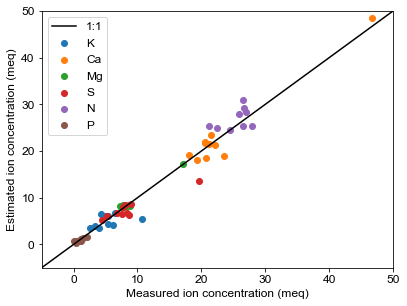

6 fold ended.
2 fold start.
Epoch:        0/   50000 cost: 4.759345, best: 0.000
Training Acc: -704.420, Test Acc: -794.503
-973.095 -1715.932 -422.736 -1563.580 -2252.812 -875.057 
-1300.5351911619716
Epoch:      500/   50000 cost: 0.375167, best: 0.000
Training Acc: -0.098, Test Acc: -0.323
-2.050 -1.080 -1.309 -0.651 -1.487 -0.734 
-1.2187052229674078
Epoch:     1000/   50000 cost: 0.154271, best: 0.000
Training Acc: 0.124, Test Acc: -0.069
-2.674 -0.528 -0.284 -0.252 -0.492 -0.616 
-0.8075988111846343
Epoch:     1003/   50000 cost: 0.304384, best: 0.065 *Best value was replaced.
-2.674 -0.528 -0.284 -0.252 -0.492 -0.616 
-0.8075988111846343
Epoch:     1004/   50000 cost: 0.244893, best: 0.094 *Best value was replaced.
-2.674 -0.528 -0.284 -0.252 -0.492 -0.616 
-0.8075988111846343
Epoch:     1005/   50000 cost: 0.385511, best: 0.139 *Best value was replaced.
-2.674 -0.528 -0.284 -0.252 -0.492 -0.616 
-0.8075988111846343
Epoch:     1008/   50000 cost: 0.116608, best: 0.151 *Best valu

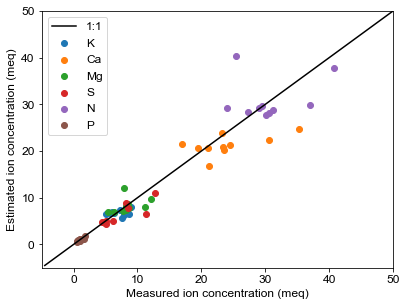

6 fold ended.
3 fold start.
Epoch:        0/   50000 cost: 6.139193, best: 0.000
Training Acc: -266.047, Test Acc: -358.253
-364.356 -553.662 -4167.234 -598.023 -217.250 -241.553 
-1023.6797994482775
Epoch:      500/   50000 cost: 0.318690, best: 0.000
Training Acc: -0.021, Test Acc: 0.098
0.615 -1.407 -3.866 -3.742 -1.889 -0.566 
-1.8089324821277046
Epoch:     1000/   50000 cost: 0.110752, best: 0.000
Training Acc: 0.107, Test Acc: 0.326
0.082 0.340 -0.485 -1.135 0.366 -1.980 
-0.4685263996108604
Epoch:     1003/   50000 cost: 0.103405, best: 0.369 *Best value was replaced.
0.082 0.340 -0.485 -1.135 0.366 -1.980 
-0.4685263996108604
Epoch:     1005/   50000 cost: 0.307393, best: 0.418 *Best value was replaced.
0.082 0.340 -0.485 -1.135 0.366 -1.980 
-0.4685263996108604
Epoch:     1006/   50000 cost: 0.139480, best: 0.451 *Best value was replaced.
0.082 0.340 -0.485 -1.135 0.366 -1.980 
-0.4685263996108604
Epoch:     1025/   50000 cost: 0.099997, best: 0.539 *Best value was replaced.
0

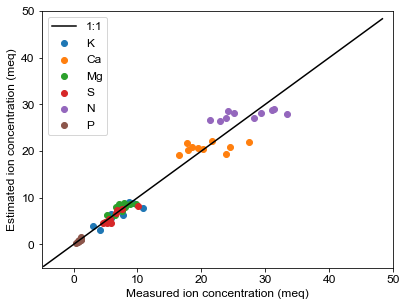

6 fold ended.
4 fold start.
Epoch:        0/   50000 cost: 7.360641, best: 0.000
Training Acc: -211.592, Test Acc: -267.196
-179.157 -9899.090 -601.163 -310.451 -579.652 -55.960 
-1937.5791304661182
Epoch:      500/   50000 cost: 0.333156, best: 0.000
Training Acc: -0.800, Test Acc: -1.633
-0.615 -16.606 -10.220 -6.229 -48.466 -1.627 
-13.960660068539902
Epoch:     1000/   50000 cost: 0.077763, best: 0.000
Training Acc: -1.958, Test Acc: -2.289
-0.148 -46.763 -7.548 -21.790 -10.199 -1.566 
-14.668878030351332
Epoch:     1232/   50000 cost: 0.068066, best: 0.011 *Best value was replaced.
-0.148 -46.763 -7.548 -21.790 -10.199 -1.566 
-14.668878030351332
Epoch:     1234/   50000 cost: 0.132750, best: 0.021 *Best value was replaced.
-0.148 -46.763 -7.548 -21.790 -10.199 -1.566 
-14.668878030351332
Epoch:     1237/   50000 cost: 0.195157, best: 0.354 *Best value was replaced.
-0.148 -46.763 -7.548 -21.790 -10.199 -1.566 
-14.668878030351332
Epoch:     1500/   50000 cost: 0.079239, best: 0.3

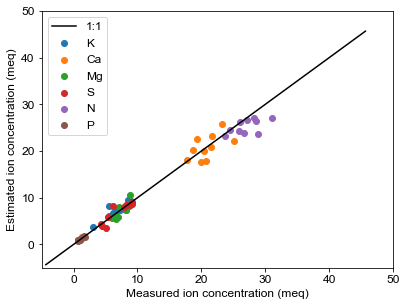

6 fold ended.
5 fold start.
Epoch:        0/   50000 cost: 8.680628, best: 0.000
Training Acc: -250.082, Test Acc: -266.612
-279.726 -237.189 -363.111 -240.131 -494.776 -227.979 
-307.15171490166597
Epoch:      500/   50000 cost: 0.142602, best: 0.000
Training Acc: 0.301, Test Acc: -0.081
-0.055 -0.746 0.110 -0.107 -0.446 0.132 
-0.1853438488438143
Epoch:     1000/   50000 cost: 0.140279, best: 0.000
Training Acc: 0.574, Test Acc: 0.119
-0.051 -0.055 0.055 0.155 -0.092 0.054 
0.011117405704226016
Epoch:     1002/   50000 cost: 0.133659, best: 0.145 *Best value was replaced.
-0.051 -0.055 0.055 0.155 -0.092 0.054 
0.011117405704226016
Epoch:     1003/   50000 cost: 0.136160, best: 0.258 *Best value was replaced.
-0.051 -0.055 0.055 0.155 -0.092 0.054 
0.011117405704226016
Epoch:     1019/   50000 cost: 0.092435, best: 0.300 *Best value was replaced.
-0.051 -0.055 0.055 0.155 -0.092 0.054 
0.011117405704226016
Epoch:     1036/   50000 cost: 0.149137, best: 0.381 *Best value was replaced.

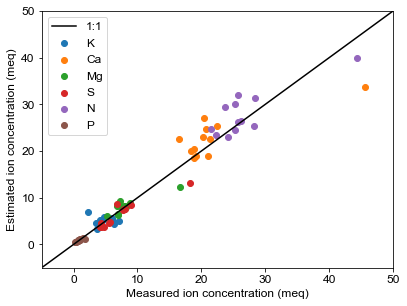

6 fold ended.
All fold vaildation were ended.
5-fold validation accuracy: 0.660


In [18]:
accuracies = []
for i in range(N_FOLD):
    print("%d fold start." % (i+1))

    pred_input = pred_inputs[i]
    pred_label = pred_labels[i]
    
    rnn_input = rnn_inputs[i]
    rnn_label = rnn_labels[i]
    
    # Parameters
    EXPLANATION = EXPLANATION_+ "_F" + str(i+1)
    LIMIT = 3002
    SHIELD = 1000
    
    global_step = tf.Variable(0, trainable=False)
    LEARNING_RATE = tf.train.exponential_decay(0.035, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.0001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 512
    N_FC_HIDDEN = 512
    DROP_PROB = 0.9
    BATCH_SIZE = 16
    DISPLAY_STEP = 500
    N_INPUT = env_input[0].shape[1]
    N_OUTPUT = ion_label.shape[1]

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    phase = tf.placeholder(tf.bool)
    
    # Define weights
    weights = tf.get_variable("F"+ str(i+1) + "wgt", shape=[N_HIDDEN, N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("F"+ str(i+1) + "bias", shape=[N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)

    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)
        
        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation
    

    def Task_specific_FC(x, n_hidden, phase, tasknum):
        h1 = BN_FC(x, n_hidden, phase, "task" + str(tasknum) + "_layer1")
        h2 = BN_FC(h1, n_hidden, phase, "task" + str(tasknum) + "_layer2")
        
        return FC(h2, 1, "task" + str(tasknum) + "_out")


    # Construct model
    shared_layer = RNN(x, weights, biases, drop_prob)
    pred_1 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 1)
    pred_2 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 2)
    pred_3 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 3)
    pred_4 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 4)
    pred_5 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 5)
    pred_6 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 6)
    pred = tf.concat([pred_1, pred_2, pred_3, pred_4, pred_5, pred_6], axis=1)


    # Define loss and optimizer
    #cost = tf.reduce_sum(tf.square(tf.subtract(pred, y)))
    cost_1 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 0], [-1, 1]), predictions=pred_1)
    cost_2 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 1], [-1, 1]), predictions=pred_2)
    cost_3 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 2], [-1, 1]), predictions=pred_3)
    cost_4 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 3], [-1, 1]), predictions=pred_4)
    cost_5 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 4], [-1, 1]), predictions=pred_5)
    cost_6 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 5], [-1, 1]), predictions=pred_6)
    joint_cost = cost_1 + cost_2 + cost_3 + cost_4 + cost_5 + cost_6
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    with tf.control_dependencies(update_ops):
        optimizer = optimizer_.minimize(joint_cost, global_step=global_step)
    tf.summary.scalar('cost', joint_cost)
    
    # Evaluate model
    total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    R_squared = tf.subtract(1., tf.divide(unexplained_error, total_error))
    
    accuracy = R_squared
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()

    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/closed_" + "F"+ str(i+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/closed_" + "F"+ str(i+1))
    sess.run(init)

    # Launch the graph
    best_pred_acc = EX_PRED
    ex_pred_acc = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()
       
    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        cost_, summary, _ = sess.run([joint_cost, merged, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
        train_writer.add_summary(summary, EPOCH)
        summary, pred_acc = sess.run([merged, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
        test_writer.add_summary(summary, EPOCH)
        
        if pred_acc > ex_pred_acc:
            if EPOCH <= SHIELD:
                pass
            elif pred_acc > best_pred_acc:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_acc = pred_acc
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
                for __ in range(N_TASKS):
                    print("%.3f"% r2_score(pred_label.iloc[:,__], R2[:,__]), end=" ")
                print("")
                print(r2_score(pred_label, R2))
        else:
            early_stop_buffer += 1

            
        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_acc = pred_acc        
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, cost_, best_pred_acc))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            for i in range(N_TASKS):
                print("%.3f"% r2_score(pred_label.iloc[:,i], R2[:,i]), end=" ")
            print("")
            print(r2_score(pred_label, R2))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))

    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    accuracies.append(final_acc)

    print ("Test accuracy:", final_acc)

    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0, phase: 0})
    prediction = (prediction * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_label = (pred_label * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_df = pd.DataFrame(prediction)
    pred_df.index = pred_label.index
    pred_df.columns = ["K", "Ca", "Mg", "S", "N", "P"]

    ion_results = pd.concat([pred_label, pred_df], axis = 1)
    ion_results.to_csv("./results/results_" + EXPLANATION + ".csv")

    x_linear = np.arange(min(ion_results.min()) - 5, max(ion_results.max()) + 15)
    y_linear = x_linear


    linear = plt.plot(x_linear, y_linear, "k-")
    for _ in range(6):
        scatter = plt.scatter(ion_results.iloc[:, _], ion_results.iloc[:, _+6])

    plt.legend(["1:1", "K", "Ca", "Mg", "S", "N", "P"])
    plt.xlabel("Measured ion concentration (meq)")
    plt.ylabel("Estimated ion concentration (meq)")
    plt.axis([-5, 50, -5, 50])
    plt.show()
    print("%d fold ended." % (i+1))
    tf.reset_default_graph()
    sess.close()

print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))